# Testing Stock Fetcher 

## Imports 

In [1]:
# Reload Custom Modules 
import importlib
import src.beta_vae
import src.data_fetching 
import src.portfolio
importlib.reload(src.beta_vae)
importlib.reload(src.data_fetching)
importlib.reload(src.portfolio)

<module 'src.portfolio' from 'c:\\Users\\jairp\\OneDrive\\Desktop_remote\\HEC Montreal\\4. Fall 2024\\Deep Learning II\\Project\\StockDiversifier\\src\\portfolio.py'>

In [2]:
# General 
import os 
import json 
import random 
from tqdm.notebook import tqdm

# Data Science
import optuna 
import numpy as np 
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# PyTorch
import torch

# Custom Classes 
from src.beta_vae import Encoder
from src.beta_vae import Decoder
from src.beta_vae import BetaVAE
from src.portfolio import Portfolio

# Custom Functions
from src.beta_vae import create_data_loaders
from src.beta_vae import create_single_data_loader
from src.beta_vae import objective
from src.beta_vae import train_beta_vae
from src.beta_vae import get_embeddings
from src.beta_vae import generate_embeddings_dict
from src.portfolio import fetch_and_calculate_returns
from src.portfolio import diversify_betavae_portfolio
from src.data_fetching import scrape_sp500_wikipedia
from src.data_fetching import fetch_stock_data
from src.data_fetching import prepare_data_for_vae

In [3]:
custom_tickers = [
    'PLTR',  # Palantir Technologies Inc. (Technology)
    'COIN',  # Coinbase Global, Inc. (Financials)
    'WDAY',  # Workday, Inc. (Technology)
    'TTD',   # The Trade Desk, Inc. (Technology)
    'APO',   # Apollo Global Management, Inc. (Financials)
    'MELI',  # MercadoLibre, Inc. (Consumer Discretionary)
    'NVO',   # Novo Nordisk A/S (Healthcare)
    'ICON',  # Icon PLC (Healthcare)
    'TSM',   # Taiwan Semiconductor Manufacturing Company Limited (Technology)
    'SKX',   # Skechers U.S.A., Inc. (Consumer Discretionary)
    'BAYRY', # Bayer AG (Healthcare)
    'DISCK', # Discovery, Inc. (Communication Services)
    'FNV',   # Franco-Nevada Corporation (Materials)
    'SHOP',  # Shopify Inc. (Technology)
    'SQ',    # Square, Inc. (Technology)
    'UBER',  # Uber Technologies, Inc. (Industrials)
    'ZM',    # Zoom Video Communications, Inc. (Technology)
    'TWLO',  # Twilio Inc. (Technology)
    'MRNA',  # Moderna, Inc. (Healthcare)
    'WDAY',  # Workday, Inc. (Technology)
    'DOCU',  # DocuSign, Inc. (Technology)
    'VEEV',  # Veeva Systems Inc. (Healthcare)
    'LULU',  # Lululemon Athletica Inc. (Consumer Discretionary)
    'ROKU',  # Roku, Inc. (Communication Services)
    'CRWD',  # CrowdStrike Holdings, Inc. (Technology)
    'SNOW',  # Snowflake Inc. (Technology)
    'NET',   # Cloudflare, Inc. (Technology)
    'PINS',  # Pinterest, Inc. (Communication Services)
    'ETSY',  # Etsy, Inc. (Consumer Discretionary)
    'SPOT',   # Spotify Technology S.A. (Communication Services)
    "AAPL", # Apple Inc. (Technology)
]

## Fetching the data 

In [4]:
# Convert ndarray values to lists for JSON serialization
def serialize_ndarray(data_dict):
    return {key: (value.tolist() if isinstance(value, np.ndarray) else value) for key, value in data_dict.items()}

# Convert lists back to ndarrays if needed
def deserialize_ndarray(data_dict):
    return {key: (np.array(value) if isinstance(value, list) else value) for key, value in data_dict.items()}

In [5]:
# Scrape S&P 500 companies names, tikers and industris from Wikipedia
sp500_df = scrape_sp500_wikipedia()  

In [6]:
# extract the tickers from the dataframe
sp500_tickers = sp500_df["Symbol"].tolist()

# check for tikers with anomalies 
anomalies = [ticker for ticker in sp500_tickers if not ticker.isalnum()]
print(anomalies)

# check if apple is in the tickers
print("AAPL" in sp500_tickers)

# show the first couple of columns 
print(sp500_df.head())

['BRK.B', 'BF.B']
True
  Symbol             Security             GICS Sector
0    MMM                   3M             Industrials
1    AOS          A. O. Smith             Industrials
2    ABT  Abbott Laboratories             Health Care
3   ABBV               AbbVie             Health Care
4    ACN            Accenture  Information Technology


In [7]:
REFETCH = True 
LOAD_RETURNS = False 

############################################################################################
### Step 1: Scrape SP500 

# Scrape S&P 500 companies names, tikers and industris from Wikipedia
sp500_df = scrape_sp500_wikipedia()  

############################################################################################
## Step 2: Fetch Stock Data Features 

if REFETCH:
    # Fetch data for all sp500 + custom tickers
    stock_data, sector_mapping, industry_mapping = fetch_stock_data(sp500_df, custom_tickers, 
                                                                    period = "1y", interval = "1wk",
                                                                    savepath="data_raw/stock_data.csv") # Fetch data
else: 
    # read data from file
    stock_data = pd.read_csv("data_raw/stock_data.csv", index_col=0).reset_index()


############################################################################################
## Step 3: Fetch Returns for all tickers

if LOAD_RETURNS:
    # Load the returns from the file
    with open("data_raw/all_returns.json", "r") as f:
        all_returns = json.load(f)

    # Deserialize loaded data
    all_returns = deserialize_ndarray(all_returns)

    # Show the first few tickers and their returns
    print("First few tickers and their returns:")
    for ticker, returns in list(all_returns.items())[:5]:
        print(f"{ticker}: {returns[:5]}...")  # Print first 5 returns for each ticker

else: 
    # Fetch and calculate returns for the all tickers in the S&P 500 and additional tickers
    all_tickers = stock_data["Ticker"].values.tolist()  # All S&P 500 tickers
    print(f"number of tickers: {len(all_tickers)}")

    # Fetch and calculate returns for all tickers
    all_returns = fetch_and_calculate_returns(all_tickers, period="1y", interval="1wk", price_column="Close")

    # Find the mode of the lengths of the returns among all tickers
    return_lengths = [len(returns) for returns in all_returns.values()]
    return_length_mode = max(set(return_lengths), key=return_lengths.count)

    # Ensure to keep only the returns with the mode length and report the discarded tickers 
    discarded_tickers = [ticker for ticker, returns in all_returns.items() if len(returns) != return_length_mode]
    all_returns = {ticker: returns for ticker, returns in all_returns.items() if len(returns) == return_length_mode}
    print(f"Discarded tickers with inconsistent return lengths: {discarded_tickers}")

    # Remove from stock_data the tickers with inconsistent return lengths
    stock_data = stock_data[stock_data["Ticker"].isin(all_returns.keys())].reset_index().drop(columns=["index"])

    print("Total number of tickers with consistent return lengths:", len(all_returns))
    print("stock_date shape:", stock_data.shape)

    # Save the dictionary with the returns to a file using json 
    with open("data_raw/all_returns.json", "w") as f:
        print(f"Saving returns to {f.name}")
        json.dump(serialize_ndarray(all_returns), f, indent=4)

############################################################################################
## Step 4: Prepare Data for VAE	

# Prepare data for VAE
stock_data_vae = prepare_data_for_vae(stock_data) 

Fetching stock data...:  21%|██▏       | 113/527 [00:34<01:49,  3.77it/s]ICON: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
ICON: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
Fetching stock data...:  56%|█████▌    | 296/527 [01:30<01:09,  3.34it/s]$DISCK: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
$DISCK: possibly delisted; no price data found  (period=1y) (Yahoo error = "No data found, symbol may be delisted")
Fetching stock data...:  61%|██████▏   | 324/527 [01:40<00:58,  3.46it/s]SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
SW: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', '6mo', 'ytd', 'max']
Fetching stock data...:  71%|███████   | 374/527 [01:56<01:08,  2.22it/s]$ROST: possibly delisted; no price data found  (period=1y)
$ROST: possibly delisted; no price data found  (p

Completed fetching stock data in 334.03 seconds.
saving data to data_raw/stock_data.csv
number of tickers: 370


Fetching Data:   0%|          | 1/370 [00:00<03:06,  1.98ticker/s]

No data found for ticker: INTU


$NSC: possibly delisted; no price data found  (period=1y)
Fetching Data:   1%|          | 2/370 [00:00<02:59,  2.05ticker/s]

No data found for ticker: NSC


$URI: possibly delisted; no price data found  (period=1y)
Fetching Data:   1%|          | 3/370 [00:01<03:00,  2.03ticker/s]

No data found for ticker: URI


$YUM: possibly delisted; no price data found  (period=1y)
Fetching Data:   1%|          | 4/370 [00:01<02:56,  2.07ticker/s]

No data found for ticker: YUM


$MOH: possibly delisted; no price data found  (period=1y)
Fetching Data:   1%|▏         | 5/370 [00:02<03:05,  1.97ticker/s]

No data found for ticker: MOH


$SPOT: possibly delisted; no price data found  (period=1y)
Fetching Data:   2%|▏         | 6/370 [00:03<03:05,  1.96ticker/s]

No data found for ticker: SPOT


$NCLH: possibly delisted; no price data found  (period=1y)
Fetching Data:   2%|▏         | 7/370 [00:03<03:02,  1.99ticker/s]

No data found for ticker: NCLH


$L: possibly delisted; no price data found  (period=1y)
Fetching Data:   2%|▏         | 8/370 [00:03<03:01,  2.00ticker/s]

No data found for ticker: L


$WMB: possibly delisted; no price data found  (period=1y)
Fetching Data:   2%|▏         | 9/370 [00:04<02:57,  2.03ticker/s]

No data found for ticker: WMB


$FDX: possibly delisted; no price data found  (period=1y)
Fetching Data:   3%|▎         | 10/370 [00:04<02:54,  2.06ticker/s]

No data found for ticker: FDX


$TRV: possibly delisted; no price data found  (period=1y)
Fetching Data:   3%|▎         | 11/370 [00:05<02:51,  2.09ticker/s]

No data found for ticker: TRV


$ED: possibly delisted; no price data found  (period=1y)
Fetching Data:   3%|▎         | 12/370 [00:05<02:50,  2.10ticker/s]

No data found for ticker: ED


$PYPL: possibly delisted; no price data found  (period=1y)
Fetching Data:   4%|▎         | 13/370 [00:06<02:47,  2.13ticker/s]

No data found for ticker: PYPL


$LVS: possibly delisted; no price data found  (period=1y)
Fetching Data:   4%|▍         | 14/370 [00:06<02:48,  2.11ticker/s]

No data found for ticker: LVS


$ANET: possibly delisted; no price data found  (period=1y)
Fetching Data:   4%|▍         | 15/370 [00:07<02:47,  2.12ticker/s]

No data found for ticker: ANET


$PM: possibly delisted; no price data found  (period=1y)
Fetching Data:   4%|▍         | 16/370 [00:07<02:46,  2.13ticker/s]

No data found for ticker: PM


$ADP: possibly delisted; no price data found  (period=1y)
Fetching Data:   5%|▍         | 17/370 [00:08<02:43,  2.16ticker/s]

No data found for ticker: ADP


$ZM: possibly delisted; no price data found  (period=1y)
Fetching Data:   5%|▍         | 18/370 [00:08<02:41,  2.18ticker/s]

No data found for ticker: ZM


$ABBV: possibly delisted; no price data found  (period=1y)
Fetching Data:   5%|▌         | 19/370 [00:09<02:39,  2.20ticker/s]

No data found for ticker: ABBV


$AVY: possibly delisted; no price data found  (period=1y)
Fetching Data:   5%|▌         | 20/370 [00:09<02:45,  2.12ticker/s]

No data found for ticker: AVY


$VLTO: possibly delisted; no price data found  (period=1y)
Fetching Data:   6%|▌         | 21/370 [00:10<02:49,  2.06ticker/s]

No data found for ticker: VLTO


$GD: possibly delisted; no price data found  (period=1y)
Fetching Data:   6%|▌         | 22/370 [00:10<02:57,  1.96ticker/s]

No data found for ticker: GD


$CDW: possibly delisted; no price data found  (period=1y)
Fetching Data:   6%|▌         | 23/370 [00:11<02:48,  2.06ticker/s]

No data found for ticker: CDW


$SNPS: possibly delisted; no price data found  (period=1y)
Fetching Data:   6%|▋         | 24/370 [00:11<02:47,  2.06ticker/s]

No data found for ticker: SNPS


$MNST: possibly delisted; no price data found  (period=1y)
Fetching Data:   7%|▋         | 25/370 [00:12<02:52,  2.00ticker/s]

No data found for ticker: MNST


$EIX: possibly delisted; no price data found  (period=1y)
Fetching Data:   7%|▋         | 26/370 [00:12<02:53,  1.98ticker/s]

No data found for ticker: EIX


$VMC: possibly delisted; no price data found  (period=1y)
Fetching Data:   7%|▋         | 27/370 [00:13<02:52,  1.98ticker/s]

No data found for ticker: VMC


$PSA: possibly delisted; no price data found  (period=1y)
Fetching Data:   8%|▊         | 28/370 [00:13<02:49,  2.02ticker/s]

No data found for ticker: PSA


$EPAM: possibly delisted; no price data found  (period=1y)
Fetching Data:   8%|▊         | 29/370 [00:14<02:42,  2.10ticker/s]

No data found for ticker: EPAM


$JCI: possibly delisted; no price data found  (period=1y)
Fetching Data:   8%|▊         | 30/370 [00:14<02:39,  2.13ticker/s]

No data found for ticker: JCI


$PFG: possibly delisted; no price data found  (period=1y)
Fetching Data:   8%|▊         | 31/370 [00:15<02:41,  2.10ticker/s]

No data found for ticker: PFG


$C: possibly delisted; no price data found  (period=1y)
Fetching Data:   9%|▊         | 32/370 [00:15<02:47,  2.02ticker/s]

No data found for ticker: C


$PAYX: possibly delisted; no price data found  (period=1y)
Fetching Data:   9%|▉         | 33/370 [00:16<02:59,  1.88ticker/s]

No data found for ticker: PAYX


$GOOG: possibly delisted; no price data found  (period=1y)
Fetching Data:   9%|▉         | 34/370 [00:16<02:51,  1.96ticker/s]

No data found for ticker: GOOG


$MAR: possibly delisted; no price data found  (period=1y)
Fetching Data:   9%|▉         | 35/370 [00:17<02:47,  2.00ticker/s]

No data found for ticker: MAR


$ANSS: possibly delisted; no price data found  (period=1y)
Fetching Data:  10%|▉         | 36/370 [00:17<02:44,  2.03ticker/s]

No data found for ticker: ANSS


$LH: possibly delisted; no price data found  (period=1y)
Fetching Data:  10%|█         | 37/370 [00:18<02:41,  2.07ticker/s]

No data found for ticker: LH


$SQ: possibly delisted; no price data found  (period=1y)
Fetching Data:  10%|█         | 38/370 [00:18<02:41,  2.06ticker/s]

No data found for ticker: SQ


$BKNG: possibly delisted; no price data found  (period=1y)
Fetching Data:  11%|█         | 39/370 [00:19<02:40,  2.06ticker/s]

No data found for ticker: BKNG


$WST: possibly delisted; no price data found  (period=1y)
Fetching Data:  11%|█         | 40/370 [00:19<02:43,  2.02ticker/s]

No data found for ticker: WST


$AZO: possibly delisted; no price data found  (period=1y)
Fetching Data:  11%|█         | 41/370 [00:19<02:40,  2.05ticker/s]

No data found for ticker: AZO


$JNJ: possibly delisted; no price data found  (period=1y)
Fetching Data:  11%|█▏        | 42/370 [00:20<02:40,  2.04ticker/s]

No data found for ticker: JNJ


$CEG: possibly delisted; no price data found  (period=1y)
Fetching Data:  12%|█▏        | 43/370 [00:20<02:40,  2.04ticker/s]

No data found for ticker: CEG


$CMG: possibly delisted; no price data found  (period=1y)
Fetching Data:  12%|█▏        | 44/370 [00:21<02:38,  2.06ticker/s]

No data found for ticker: CMG


$CF: possibly delisted; no price data found  (period=1y)
Fetching Data:  12%|█▏        | 45/370 [00:21<02:37,  2.06ticker/s]

No data found for ticker: CF


$LW: possibly delisted; no price data found  (period=1y)
Fetching Data:  12%|█▏        | 46/370 [00:22<02:34,  2.09ticker/s]

No data found for ticker: LW


$GL: possibly delisted; no price data found  (period=1y)
Fetching Data:  13%|█▎        | 47/370 [00:23<04:14,  1.27ticker/s]

No data found for ticker: GL


$ICE: possibly delisted; no price data found  (period=1y)
Fetching Data:  13%|█▎        | 48/370 [00:24<03:49,  1.40ticker/s]

No data found for ticker: ICE


$FTV: possibly delisted; no price data found  (period=1y)
Fetching Data:  13%|█▎        | 49/370 [00:24<03:25,  1.56ticker/s]

No data found for ticker: FTV


$CSCO: possibly delisted; no price data found  (period=1y)
Fetching Data:  14%|█▎        | 50/370 [00:26<04:47,  1.11ticker/s]

No data found for ticker: CSCO


$FICO: possibly delisted; no price data found  (period=1y)
Fetching Data:  14%|█▍        | 51/370 [00:26<04:14,  1.26ticker/s]

No data found for ticker: FICO


$MCO: possibly delisted; no price data found  (period=1y)
Fetching Data:  14%|█▍        | 52/370 [00:27<03:39,  1.45ticker/s]

No data found for ticker: MCO


$GPC: possibly delisted; no price data found  (period=1y)
Fetching Data:  14%|█▍        | 53/370 [00:28<04:12,  1.26ticker/s]

No data found for ticker: GPC


$LKQ: possibly delisted; no price data found  (period=1y)
Fetching Data:  15%|█▍        | 54/370 [00:28<03:44,  1.41ticker/s]

No data found for ticker: LKQ


$SWK: possibly delisted; no price data found  (period=1y)
Fetching Data:  15%|█▍        | 55/370 [00:29<03:22,  1.56ticker/s]

No data found for ticker: SWK


$ZBRA: possibly delisted; no price data found  (period=1y)
Fetching Data:  15%|█▌        | 56/370 [00:29<03:06,  1.68ticker/s]

No data found for ticker: ZBRA


$CSGP: possibly delisted; no price data found  (period=1y)
Fetching Data:  15%|█▌        | 57/370 [00:30<02:55,  1.79ticker/s]

No data found for ticker: CSGP


$FCX: possibly delisted; no price data found  (period=1y)
Fetching Data:  16%|█▌        | 58/370 [00:30<02:48,  1.85ticker/s]

No data found for ticker: FCX


$CRWD: possibly delisted; no price data found  (period=1y)
Fetching Data:  16%|█▌        | 59/370 [00:31<02:44,  1.89ticker/s]

No data found for ticker: CRWD


$PGR: possibly delisted; no price data found  (period=1y)
Fetching Data:  16%|█▌        | 60/370 [00:31<02:41,  1.92ticker/s]

No data found for ticker: PGR


$PEG: possibly delisted; no price data found  (period=1y)
Fetching Data:  16%|█▋        | 61/370 [00:32<02:35,  1.99ticker/s]

No data found for ticker: PEG


$NTAP: possibly delisted; no price data found  (period=1y)
Fetching Data:  17%|█▋        | 62/370 [00:32<02:28,  2.07ticker/s]

No data found for ticker: NTAP


$CMCSA: possibly delisted; no price data found  (period=1y)
Fetching Data:  17%|█▋        | 63/370 [00:33<02:31,  2.03ticker/s]

No data found for ticker: CMCSA


$TXN: possibly delisted; no price data found  (period=1y)
Fetching Data:  17%|█▋        | 64/370 [00:33<02:33,  1.99ticker/s]

No data found for ticker: TXN


$GDDY: possibly delisted; no price data found  (period=1y)
Fetching Data:  18%|█▊        | 65/370 [00:34<02:27,  2.07ticker/s]

No data found for ticker: GDDY


$SHOP: possibly delisted; no price data found  (period=1y)
Fetching Data:  18%|█▊        | 66/370 [00:34<02:22,  2.13ticker/s]

No data found for ticker: SHOP


$V: possibly delisted; no price data found  (period=1y)
Fetching Data:  18%|█▊        | 67/370 [00:35<02:23,  2.11ticker/s]

No data found for ticker: V


$CARR: possibly delisted; no price data found  (period=1y)
Fetching Data:  18%|█▊        | 68/370 [00:35<02:24,  2.09ticker/s]

No data found for ticker: CARR


$AMGN: possibly delisted; no price data found  (period=1y)
Fetching Data:  19%|█▊        | 69/370 [00:36<02:27,  2.05ticker/s]

No data found for ticker: AMGN


$KIM: possibly delisted; no price data found  (period=1y)
Fetching Data:  19%|█▉        | 70/370 [00:36<02:26,  2.04ticker/s]

No data found for ticker: KIM


$TER: possibly delisted; no price data found  (period=1y)
Fetching Data:  19%|█▉        | 71/370 [00:37<02:28,  2.01ticker/s]

No data found for ticker: TER


$ABNB: possibly delisted; no price data found  (period=1y)
Fetching Data:  19%|█▉        | 72/370 [00:37<02:28,  2.01ticker/s]

No data found for ticker: ABNB


$OMC: possibly delisted; no price data found  (period=1y)
Fetching Data:  20%|█▉        | 73/370 [00:38<02:24,  2.05ticker/s]

No data found for ticker: OMC


$SMCI: possibly delisted; no price data found  (period=1y)
Fetching Data:  20%|██        | 74/370 [00:38<02:22,  2.07ticker/s]

No data found for ticker: SMCI


$LDOS: possibly delisted; no price data found  (period=1y)
Fetching Data:  20%|██        | 75/370 [00:39<02:27,  2.00ticker/s]

No data found for ticker: LDOS


$QCOM: possibly delisted; no price data found  (period=1y)
Fetching Data:  21%|██        | 76/370 [00:39<02:25,  2.03ticker/s]

No data found for ticker: QCOM


$MTCH: possibly delisted; no price data found  (period=1y)
Fetching Data:  21%|██        | 77/370 [00:40<02:23,  2.04ticker/s]

No data found for ticker: MTCH


$PCAR: possibly delisted; no price data found  (period=1y)
Fetching Data:  21%|██        | 78/370 [00:40<02:27,  1.98ticker/s]

No data found for ticker: PCAR


$GIS: possibly delisted; no price data found  (period=1y)
Fetching Data:  21%|██▏       | 79/370 [00:41<02:26,  1.98ticker/s]

No data found for ticker: GIS


$AKAM: possibly delisted; no price data found  (period=1y)
Fetching Data:  22%|██▏       | 80/370 [00:41<02:26,  1.98ticker/s]

No data found for ticker: AKAM


$PODD: possibly delisted; no price data found  (period=1y)
Fetching Data:  22%|██▏       | 81/370 [00:42<02:24,  1.99ticker/s]

No data found for ticker: PODD


$UPS: possibly delisted; no price data found  (period=1y)
Fetching Data:  22%|██▏       | 82/370 [00:42<02:19,  2.07ticker/s]

No data found for ticker: UPS


$WYNN: possibly delisted; no price data found  (period=1y)
Fetching Data:  22%|██▏       | 83/370 [00:43<02:22,  2.01ticker/s]

No data found for ticker: WYNN


$IEX: possibly delisted; no price data found  (period=1y)
Fetching Data:  23%|██▎       | 84/370 [00:43<02:23,  2.00ticker/s]

No data found for ticker: IEX


$IVZ: possibly delisted; no price data found  (period=1y)
Fetching Data:  23%|██▎       | 85/370 [00:44<02:25,  1.96ticker/s]

No data found for ticker: IVZ


$MAA: possibly delisted; no price data found  (period=1y)
Fetching Data:  23%|██▎       | 86/370 [00:44<02:26,  1.93ticker/s]

No data found for ticker: MAA


$UHS: possibly delisted; no price data found  (period=1y)
Fetching Data:  24%|██▎       | 87/370 [00:45<02:21,  2.00ticker/s]

No data found for ticker: UHS


$CCL: possibly delisted; no price data found  (period=1y)
Fetching Data:  24%|██▍       | 88/370 [00:45<02:20,  2.01ticker/s]

No data found for ticker: CCL


$CMS: possibly delisted; no price data found  (period=1y)
Fetching Data:  24%|██▍       | 89/370 [00:46<02:16,  2.06ticker/s]

No data found for ticker: CMS


$INVH: possibly delisted; no price data found  (period=1y)
Fetching Data:  24%|██▍       | 90/370 [00:46<02:13,  2.09ticker/s]

No data found for ticker: INVH


$NRG: possibly delisted; no price data found  (period=1y)
Fetching Data:  25%|██▍       | 91/370 [00:47<02:14,  2.08ticker/s]

No data found for ticker: NRG


$XOM: possibly delisted; no price data found  (period=1y)
Fetching Data:  25%|██▍       | 92/370 [00:47<02:14,  2.06ticker/s]

No data found for ticker: XOM


$AAPL: possibly delisted; no price data found  (period=1y)
Fetching Data:  25%|██▌       | 93/370 [00:48<02:13,  2.08ticker/s]

No data found for ticker: AAPL


$TFC: possibly delisted; no price data found  (period=1y)
Fetching Data:  25%|██▌       | 94/370 [00:48<02:11,  2.11ticker/s]

No data found for ticker: TFC


$ESS: possibly delisted; no price data found  (period=1y)
Fetching Data:  26%|██▌       | 95/370 [00:49<02:12,  2.08ticker/s]

No data found for ticker: ESS


$FFIV: possibly delisted; no price data found  (period=1y)
Fetching Data:  26%|██▌       | 96/370 [00:49<02:11,  2.09ticker/s]

No data found for ticker: FFIV


$DLR: possibly delisted; no price data found  (period=1y)
Fetching Data:  26%|██▌       | 97/370 [00:49<02:11,  2.07ticker/s]

No data found for ticker: DLR


$DG: possibly delisted; no price data found  (period=1y)
Fetching Data:  26%|██▋       | 98/370 [00:50<02:13,  2.03ticker/s]

No data found for ticker: DG


$CE: possibly delisted; no price data found  (period=1y)
Fetching Data:  27%|██▋       | 99/370 [00:50<02:11,  2.06ticker/s]

No data found for ticker: CE


$DTE: possibly delisted; no price data found  (period=1y)
Fetching Data:  27%|██▋       | 100/370 [00:51<02:11,  2.06ticker/s]

No data found for ticker: DTE


$WDAY: possibly delisted; no price data found  (period=1y)
Fetching Data:  27%|██▋       | 101/370 [00:52<02:15,  1.98ticker/s]

No data found for ticker: WDAY


$STT: possibly delisted; no price data found  (period=1y)
Fetching Data:  28%|██▊       | 102/370 [00:52<02:16,  1.96ticker/s]

No data found for ticker: STT


$LYV: possibly delisted; no price data found  (period=1y)
Fetching Data:  28%|██▊       | 103/370 [00:53<02:13,  2.00ticker/s]

No data found for ticker: LYV


$AVB: possibly delisted; no price data found  (period=1y)
Fetching Data:  28%|██▊       | 104/370 [00:53<02:10,  2.03ticker/s]

No data found for ticker: AVB


$NXPI: possibly delisted; no price data found  (period=1y)
Fetching Data:  28%|██▊       | 105/370 [00:53<02:07,  2.08ticker/s]

No data found for ticker: NXPI


$BRO: possibly delisted; no price data found  (period=1y)
Fetching Data:  29%|██▊       | 106/370 [00:54<02:05,  2.10ticker/s]

No data found for ticker: BRO


$DVN: possibly delisted; no price data found  (period=1y)
Fetching Data:  29%|██▉       | 107/370 [00:54<02:03,  2.13ticker/s]

No data found for ticker: DVN


$SPG: possibly delisted; no price data found  (period=1y)
Fetching Data:  29%|██▉       | 108/370 [00:55<02:03,  2.12ticker/s]

No data found for ticker: SPG


$TYL: possibly delisted; no price data found  (period=1y)
Fetching Data:  29%|██▉       | 109/370 [00:55<02:04,  2.09ticker/s]

No data found for ticker: TYL


$ENPH: possibly delisted; no price data found  (period=1y)
Fetching Data:  30%|██▉       | 110/370 [00:56<02:01,  2.13ticker/s]

No data found for ticker: ENPH


$CAG: possibly delisted; no price data found  (period=1y)
Fetching Data:  30%|███       | 111/370 [00:56<02:00,  2.15ticker/s]

No data found for ticker: CAG


$PINS: possibly delisted; no price data found  (period=1y)
Fetching Data:  30%|███       | 112/370 [00:57<02:03,  2.09ticker/s]

No data found for ticker: PINS


$CME: possibly delisted; no price data found  (period=1y)
Fetching Data:  31%|███       | 113/370 [00:57<02:07,  2.02ticker/s]

No data found for ticker: CME


$ZTS: possibly delisted; no price data found  (period=1y)
Fetching Data:  31%|███       | 114/370 [00:58<02:04,  2.06ticker/s]

No data found for ticker: ZTS


$VRSN: possibly delisted; no price data found  (period=1y)
Fetching Data:  31%|███       | 115/370 [00:58<02:00,  2.11ticker/s]

No data found for ticker: VRSN


$WMT: possibly delisted; no price data found  (period=1y)
Fetching Data:  31%|███▏      | 116/370 [00:59<02:00,  2.12ticker/s]

No data found for ticker: WMT


$D: possibly delisted; no price data found  (period=1y)
Fetching Data:  32%|███▏      | 117/370 [00:59<01:59,  2.11ticker/s]

No data found for ticker: D


$CMI: possibly delisted; no price data found  (period=1y)
Fetching Data:  32%|███▏      | 118/370 [01:00<02:00,  2.10ticker/s]

No data found for ticker: CMI


$GLW: possibly delisted; no price data found  (period=1y)
Fetching Data:  32%|███▏      | 119/370 [01:00<02:01,  2.07ticker/s]

No data found for ticker: GLW


$GPN: possibly delisted; no price data found  (period=1y)
Fetching Data:  32%|███▏      | 120/370 [01:01<01:59,  2.08ticker/s]

No data found for ticker: GPN


$IRM: possibly delisted; no price data found  (period=1y)
Fetching Data:  33%|███▎      | 121/370 [01:01<01:58,  2.11ticker/s]

No data found for ticker: IRM


$EMN: possibly delisted; no price data found  (period=1y)
Fetching Data:  33%|███▎      | 122/370 [01:01<01:55,  2.15ticker/s]

No data found for ticker: EMN


$LUV: possibly delisted; no price data found  (period=1y)
Fetching Data:  33%|███▎      | 123/370 [01:02<01:57,  2.10ticker/s]

No data found for ticker: LUV


$PHM: possibly delisted; no price data found  (period=1y)
Fetching Data:  34%|███▎      | 124/370 [01:03<01:59,  2.05ticker/s]

No data found for ticker: PHM


$WFC: possibly delisted; no price data found  (period=1y)
Fetching Data:  34%|███▍      | 125/370 [01:03<01:57,  2.09ticker/s]

No data found for ticker: WFC


$J: possibly delisted; no price data found  (period=1y)
Fetching Data:  34%|███▍      | 126/370 [01:03<01:56,  2.09ticker/s]

No data found for ticker: J


$BLK: possibly delisted; no price data found  (period=1y)
Fetching Data:  34%|███▍      | 127/370 [01:04<01:57,  2.06ticker/s]

No data found for ticker: BLK


$GE: possibly delisted; no price data found  (period=1y)
Fetching Data:  35%|███▍      | 128/370 [01:04<01:56,  2.07ticker/s]

No data found for ticker: GE


$LNT: possibly delisted; no price data found  (period=1y)
Fetching Data:  35%|███▍      | 129/370 [01:05<01:56,  2.07ticker/s]

No data found for ticker: LNT


$HAS: possibly delisted; no price data found  (period=1y)
Fetching Data:  35%|███▌      | 130/370 [01:05<01:54,  2.09ticker/s]

No data found for ticker: HAS


$INCY: possibly delisted; no price data found  (period=1y)
Fetching Data:  35%|███▌      | 131/370 [01:06<01:54,  2.09ticker/s]

No data found for ticker: INCY


$FOXA: possibly delisted; no price data found  (period=1y)
Fetching Data:  36%|███▌      | 132/370 [01:06<01:56,  2.04ticker/s]

No data found for ticker: FOXA


$TAP: possibly delisted; no price data found  (period=1y)
Fetching Data:  36%|███▌      | 133/370 [01:07<01:55,  2.05ticker/s]

No data found for ticker: TAP


$TDG: possibly delisted; no price data found  (period=1y)
Fetching Data:  36%|███▌      | 134/370 [01:07<01:56,  2.03ticker/s]

No data found for ticker: TDG


$PANW: possibly delisted; no price data found  (period=1y)
Fetching Data:  36%|███▋      | 135/370 [01:08<01:57,  1.99ticker/s]

No data found for ticker: PANW


$AIZ: possibly delisted; no price data found  (period=1y)
Fetching Data:  37%|███▋      | 136/370 [01:08<01:53,  2.06ticker/s]

No data found for ticker: AIZ


$GOOGL: possibly delisted; no price data found  (period=1y)
Fetching Data:  37%|███▋      | 137/370 [01:09<01:50,  2.10ticker/s]

No data found for ticker: GOOGL


$DELL: possibly delisted; no price data found  (period=1y)
Fetching Data:  37%|███▋      | 138/370 [01:09<01:48,  2.13ticker/s]

No data found for ticker: DELL


$HOLX: possibly delisted; no price data found  (period=1y)
Fetching Data:  38%|███▊      | 139/370 [01:10<01:46,  2.16ticker/s]

No data found for ticker: HOLX


$AOS: possibly delisted; no price data found  (period=1y)
Fetching Data:  38%|███▊      | 140/370 [01:10<01:51,  2.06ticker/s]

No data found for ticker: AOS


$PLTR: possibly delisted; no price data found  (period=1y)
Fetching Data:  38%|███▊      | 141/370 [01:11<01:51,  2.06ticker/s]

No data found for ticker: PLTR


$GM: possibly delisted; no price data found  (period=1y)
Fetching Data:  38%|███▊      | 142/370 [01:11<01:49,  2.09ticker/s]

No data found for ticker: GM


$BK: possibly delisted; no price data found  (period=1y)
Fetching Data:  39%|███▊      | 143/370 [01:12<01:47,  2.11ticker/s]

No data found for ticker: BK


$KLAC: possibly delisted; no price data found  (period=1y)
Fetching Data:  39%|███▉      | 144/370 [01:12<01:52,  2.01ticker/s]

No data found for ticker: KLAC


$CHTR: possibly delisted; no price data found  (period=1y)
Fetching Data:  39%|███▉      | 145/370 [01:13<01:48,  2.07ticker/s]

No data found for ticker: CHTR


$AXP: possibly delisted; no price data found  (period=1y)
Fetching Data:  39%|███▉      | 146/370 [01:13<01:47,  2.09ticker/s]

No data found for ticker: AXP


$HD: possibly delisted; no price data found  (period=1y)
Fetching Data:  40%|███▉      | 147/370 [01:14<01:49,  2.04ticker/s]

No data found for ticker: HD


$STLD: possibly delisted; no price data found  (period=1y)
Fetching Data:  40%|████      | 148/370 [01:14<01:45,  2.10ticker/s]

No data found for ticker: STLD


$BR: possibly delisted; no price data found  (period=1y)
Fetching Data:  40%|████      | 149/370 [01:15<01:47,  2.05ticker/s]

No data found for ticker: BR


$CPT: possibly delisted; no price data found  (period=1y)
Fetching Data:  41%|████      | 150/370 [01:15<01:44,  2.10ticker/s]

No data found for ticker: CPT


$CVX: possibly delisted; no price data found  (period=1y)
Fetching Data:  41%|████      | 151/370 [01:15<01:42,  2.14ticker/s]

No data found for ticker: CVX


$BRK-B: possibly delisted; no price data found  (period=1y)
Fetching Data:  41%|████      | 152/370 [01:16<01:43,  2.11ticker/s]

No data found for ticker: BRK-B


$GILD: possibly delisted; no price data found  (period=1y)
Fetching Data:  41%|████▏     | 153/370 [01:16<01:42,  2.12ticker/s]

No data found for ticker: GILD


$ACN: possibly delisted; no price data found  (period=1y)
Fetching Data:  42%|████▏     | 154/370 [01:17<01:43,  2.08ticker/s]

No data found for ticker: ACN


$CTAS: possibly delisted; no price data found  (period=1y)
Fetching Data:  42%|████▏     | 155/370 [01:17<01:43,  2.07ticker/s]

No data found for ticker: CTAS


$SLB: possibly delisted; no price data found  (period=1y)
Fetching Data:  42%|████▏     | 156/370 [01:18<01:41,  2.10ticker/s]

No data found for ticker: SLB


$CVS: possibly delisted; no price data found  (period=1y)
Fetching Data:  42%|████▏     | 157/370 [01:19<02:00,  1.77ticker/s]

No data found for ticker: CVS


$PFE: possibly delisted; no price data found  (period=1y)
Fetching Data:  43%|████▎     | 158/370 [01:19<02:13,  1.59ticker/s]

No data found for ticker: PFE


$WDC: possibly delisted; no price data found  (period=1y)
Fetching Data:  43%|████▎     | 159/370 [01:20<02:09,  1.63ticker/s]

No data found for ticker: WDC


$WELL: possibly delisted; no price data found  (period=1y)
Fetching Data:  43%|████▎     | 160/370 [01:21<02:02,  1.71ticker/s]

No data found for ticker: WELL


$GEHC: possibly delisted; no price data found  (period=1y)
Fetching Data:  44%|████▎     | 161/370 [01:21<01:57,  1.78ticker/s]

No data found for ticker: GEHC


$MRK: possibly delisted; no price data found  (period=1y)
Fetching Data:  44%|████▍     | 162/370 [01:21<01:50,  1.89ticker/s]

No data found for ticker: MRK


$AES: possibly delisted; no price data found  (period=1y)
Fetching Data:  44%|████▍     | 163/370 [01:22<01:45,  1.96ticker/s]

No data found for ticker: AES


$MKC: possibly delisted; no price data found  (period=1y)
Fetching Data:  44%|████▍     | 164/370 [01:22<01:42,  2.01ticker/s]

No data found for ticker: MKC


$HCA: possibly delisted; no price data found  (period=1y)
Fetching Data:  45%|████▍     | 165/370 [01:23<01:37,  2.09ticker/s]

No data found for ticker: HCA


$JNPR: possibly delisted; no price data found  (period=1y)
Fetching Data:  45%|████▍     | 166/370 [01:23<01:37,  2.09ticker/s]

No data found for ticker: JNPR


$AXON: possibly delisted; no price data found  (period=1y)
Fetching Data:  45%|████▌     | 167/370 [01:24<01:36,  2.10ticker/s]

No data found for ticker: AXON


$CDNS: possibly delisted; no price data found  (period=1y)
Fetching Data:  45%|████▌     | 168/370 [01:24<01:37,  2.08ticker/s]

No data found for ticker: CDNS


$NOW: possibly delisted; no price data found  (period=1y)
Fetching Data:  46%|████▌     | 169/370 [01:25<01:36,  2.09ticker/s]

No data found for ticker: NOW


$MSCI: possibly delisted; no price data found  (period=1y)
Fetching Data:  46%|████▌     | 170/370 [01:25<01:34,  2.11ticker/s]

No data found for ticker: MSCI


$ADBE: possibly delisted; no price data found  (period=1y)
Fetching Data:  46%|████▌     | 171/370 [01:26<01:32,  2.15ticker/s]

No data found for ticker: ADBE


$TRMB: possibly delisted; no price data found  (period=1y)
Fetching Data:  46%|████▋     | 172/370 [01:26<01:33,  2.12ticker/s]

No data found for ticker: TRMB


$DOW: possibly delisted; no price data found  (period=1y)
Fetching Data:  47%|████▋     | 173/370 [01:27<01:35,  2.07ticker/s]

No data found for ticker: DOW


$SBUX: possibly delisted; no price data found  (period=1y)
Fetching Data:  47%|████▋     | 174/370 [01:27<01:37,  2.01ticker/s]

No data found for ticker: SBUX


$CFG: possibly delisted; no price data found  (period=1y)
Fetching Data:  47%|████▋     | 175/370 [01:28<01:35,  2.05ticker/s]

No data found for ticker: CFG


$FOX: possibly delisted; no price data found  (period=1y)
Fetching Data:  48%|████▊     | 176/370 [01:28<01:31,  2.11ticker/s]

No data found for ticker: FOX


$STZ: possibly delisted; no price data found  (period=1y)
Fetching Data:  48%|████▊     | 177/370 [01:29<01:29,  2.16ticker/s]

No data found for ticker: STZ


$CI: possibly delisted; no price data found  (period=1y)
Fetching Data:  48%|████▊     | 178/370 [01:29<01:32,  2.08ticker/s]

No data found for ticker: CI


$AFL: possibly delisted; no price data found  (period=1y)
Fetching Data:  48%|████▊     | 179/370 [01:30<01:33,  2.05ticker/s]

No data found for ticker: AFL


$MCD: possibly delisted; no price data found  (period=1y)
Fetching Data:  49%|████▊     | 180/370 [01:30<01:31,  2.08ticker/s]

No data found for ticker: MCD


$ROKU: possibly delisted; no price data found  (period=1y)
Fetching Data:  49%|████▉     | 181/370 [01:31<01:31,  2.06ticker/s]

No data found for ticker: ROKU


$TT: possibly delisted; no price data found  (period=1y)
Fetching Data:  49%|████▉     | 182/370 [01:31<01:30,  2.09ticker/s]

No data found for ticker: TT


$BSX: possibly delisted; no price data found  (period=1y)
Fetching Data:  49%|████▉     | 183/370 [01:31<01:27,  2.13ticker/s]

No data found for ticker: BSX


$POOL: possibly delisted; no price data found  (period=1y)
Fetching Data:  50%|████▉     | 184/370 [01:32<01:26,  2.15ticker/s]

No data found for ticker: POOL


$CTLT: possibly delisted; no price data found  (period=1y)
Fetching Data:  50%|█████     | 185/370 [01:32<01:25,  2.16ticker/s]

No data found for ticker: CTLT


$MPC: possibly delisted; no price data found  (period=1y)
Fetching Data:  50%|█████     | 186/370 [01:33<01:23,  2.21ticker/s]

No data found for ticker: MPC


$ADI: possibly delisted; no price data found  (period=1y)
Fetching Data:  51%|█████     | 187/370 [01:33<01:23,  2.19ticker/s]

No data found for ticker: ADI


$EXPE: possibly delisted; no price data found  (period=1y)
Fetching Data:  51%|█████     | 188/370 [01:34<01:22,  2.21ticker/s]

No data found for ticker: EXPE


$MAS: possibly delisted; no price data found  (period=1y)
Fetching Data:  51%|█████     | 189/370 [01:34<01:23,  2.16ticker/s]

No data found for ticker: MAS


$GEV: possibly delisted; no price data found  (period=1y)
Fetching Data:  51%|█████▏    | 190/370 [01:35<01:23,  2.15ticker/s]

No data found for ticker: GEV


$OTIS: possibly delisted; no price data found  (period=1y)
Fetching Data:  52%|█████▏    | 191/370 [01:35<01:23,  2.15ticker/s]

No data found for ticker: OTIS


$RF: possibly delisted; no price data found  (period=1y)
Fetching Data:  52%|█████▏    | 192/370 [01:36<01:22,  2.15ticker/s]

No data found for ticker: RF


$ERIE: possibly delisted; no price data found  (period=1y)
Fetching Data:  52%|█████▏    | 193/370 [01:36<01:22,  2.16ticker/s]

No data found for ticker: ERIE


$REGN: possibly delisted; no price data found  (period=1y)
Fetching Data:  52%|█████▏    | 194/370 [01:36<01:20,  2.20ticker/s]

No data found for ticker: REGN


$MLM: possibly delisted; no price data found  (period=1y)
Fetching Data:  53%|█████▎    | 195/370 [01:37<01:20,  2.16ticker/s]

No data found for ticker: MLM


$FMC: possibly delisted; no price data found  (period=1y)
Fetching Data:  53%|█████▎    | 196/370 [01:37<01:20,  2.17ticker/s]

No data found for ticker: FMC


$BX: possibly delisted; no price data found  (period=1y)
Fetching Data:  53%|█████▎    | 197/370 [01:38<01:19,  2.18ticker/s]

No data found for ticker: BX


$NTRS: possibly delisted; no price data found  (period=1y)
Fetching Data:  54%|█████▎    | 198/370 [01:38<01:20,  2.15ticker/s]

No data found for ticker: NTRS


$RJF: possibly delisted; no price data found  (period=1y)
Fetching Data:  54%|█████▍    | 199/370 [01:39<01:18,  2.19ticker/s]

No data found for ticker: RJF


$MTB: possibly delisted; no price data found  (period=1y)
Fetching Data:  54%|█████▍    | 200/370 [01:39<01:17,  2.20ticker/s]

No data found for ticker: MTB


$TSM: possibly delisted; no price data found  (period=1y)
Fetching Data:  54%|█████▍    | 201/370 [01:40<01:28,  1.92ticker/s]

No data found for ticker: TSM


$DOCU: possibly delisted; no price data found  (period=1y)
Fetching Data:  55%|█████▍    | 202/370 [01:40<01:26,  1.95ticker/s]

No data found for ticker: DOCU


$WAB: possibly delisted; no price data found  (period=1y)
Fetching Data:  55%|█████▍    | 203/370 [01:41<01:24,  1.98ticker/s]

No data found for ticker: WAB


$KO: possibly delisted; no price data found  (period=1y)
Fetching Data:  55%|█████▌    | 204/370 [01:41<01:20,  2.06ticker/s]

No data found for ticker: KO


$T: possibly delisted; no price data found  (period=1y)
Fetching Data:  55%|█████▌    | 205/370 [01:42<01:19,  2.07ticker/s]

No data found for ticker: T


$PAYC: possibly delisted; no price data found  (period=1y)
Fetching Data:  56%|█████▌    | 206/370 [01:42<01:22,  1.98ticker/s]

No data found for ticker: PAYC


$HRL: possibly delisted; no price data found  (period=1y)
Fetching Data:  56%|█████▌    | 207/370 [01:43<01:21,  2.00ticker/s]

No data found for ticker: HRL


$ELV: possibly delisted; no price data found  (period=1y)
Fetching Data:  56%|█████▌    | 208/370 [01:43<01:20,  2.00ticker/s]

No data found for ticker: ELV


$PPL: possibly delisted; no price data found  (period=1y)
Fetching Data:  56%|█████▋    | 209/370 [01:44<01:22,  1.95ticker/s]

No data found for ticker: PPL


$MSI: possibly delisted; no price data found  (period=1y)
Fetching Data:  57%|█████▋    | 210/370 [01:44<01:19,  2.01ticker/s]

No data found for ticker: MSI


$HES: possibly delisted; no price data found  (period=1y)
Fetching Data:  57%|█████▋    | 211/370 [01:45<01:18,  2.03ticker/s]

No data found for ticker: HES


$BALL: possibly delisted; no price data found  (period=1y)
Fetching Data:  57%|█████▋    | 212/370 [01:45<01:16,  2.06ticker/s]

No data found for ticker: BALL


$BAYRY: possibly delisted; no price data found  (period=1y)
Fetching Data:  58%|█████▊    | 213/370 [01:46<01:16,  2.05ticker/s]

No data found for ticker: BAYRY


$DD: possibly delisted; no price data found  (period=1y)
Fetching Data:  58%|█████▊    | 214/370 [01:46<01:15,  2.06ticker/s]

No data found for ticker: DD


$VTR: possibly delisted; no price data found  (period=1y)
Fetching Data:  58%|█████▊    | 215/370 [01:47<01:13,  2.11ticker/s]

No data found for ticker: VTR


$CNP: possibly delisted; no price data found  (period=1y)
Fetching Data:  58%|█████▊    | 216/370 [01:47<01:14,  2.06ticker/s]

No data found for ticker: CNP


$MO: possibly delisted; no price data found  (period=1y)
Fetching Data:  59%|█████▊    | 217/370 [01:48<01:14,  2.05ticker/s]

No data found for ticker: MO


$HUBB: possibly delisted; no price data found  (period=1y)
Fetching Data:  59%|█████▉    | 218/370 [01:48<01:11,  2.11ticker/s]$NVDA: possibly delisted; no price data found  (period=1y)
$NOC: possibly delisted; no price data found  (period=1y)
$SO: possibly delisted; no price data found  (period=1y)
$NDAQ: possibly delisted; no price data found  (period=1y)
$IDXX: possibly delisted; no price data found  (period=1y)
$AMZN: possibly delisted; no price data found  (period=1y)
$EQT: possibly delisted; no price data found  (period=1y)
$JPM: possibly delisted; no price data found  (period=1y)
$COIN: possibly delisted; no price data found  (period=1y)
$CAH: possibly delisted; no price data found  (period=1y)
$HLT: possibly delisted; no price data found  (period=1y)
$ORLY: possibly delisted; no price data found  (period=1y)
$SYK: possibly delisted; no price data found  (period=1y)
$ALL: possibly delisted; no price data found  (period=1y)
$DAY: possibly delisted; no price data found  (period=1y

No data found for ticker: HUBB
No data found for ticker: NVDA
No data found for ticker: NOC
No data found for ticker: SO
No data found for ticker: NDAQ
No data found for ticker: IDXX
No data found for ticker: AMZN
No data found for ticker: EQT
No data found for ticker: JPM
No data found for ticker: COIN
No data found for ticker: CAH
No data found for ticker: HLT
No data found for ticker: ORLY
No data found for ticker: SYK
No data found for ticker: ALL
No data found for ticker: DAY
No data found for ticker: EOG
No data found for ticker: KKR
No data found for ticker: WM
No data found for ticker: SJM
No data found for ticker: WTW
No data found for ticker: MHK
No data found for ticker: TPR
No data found for ticker: PNW
No data found for ticker: AJG
No data found for ticker: WRB
No data found for ticker: INTC


$ETSY: possibly delisted; no price data found  (period=1y)
$FIS: possibly delisted; no price data found  (period=1y)
$RL: possibly delisted; no price data found  (period=1y)
$CINF: possibly delisted; no price data found  (period=1y)
Fetching Data:  67%|██████▋   | 248/370 [01:48<00:04, 28.53ticker/s]$KMB: possibly delisted; no price data found  (period=1y)
$CRM: possibly delisted; no price data found  (period=1y)
$BMY: possibly delisted; no price data found  (period=1y)
$DXCM: possibly delisted; no price data found  (period=1y)
$CPB: possibly delisted; no price data found  (period=1y)
$KEY: possibly delisted; no price data found  (period=1y)
$UBER: possibly delisted; no price data found  (period=1y)
$GEN: possibly delisted; no price data found  (period=1y)
$CHRW: possibly delisted; no price data found  (period=1y)
$SYF: possibly delisted; no price data found  (period=1y)
$LRCX: possibly delisted; no price data found  (period=1y)
$MGM: possibly delisted; no price data found  (period=1y)

No data found for ticker: ETSY
No data found for ticker: FIS
No data found for ticker: RL
No data found for ticker: CINF
No data found for ticker: KMB
No data found for ticker: CRM
No data found for ticker: BMY
No data found for ticker: DXCM
No data found for ticker: CPB
No data found for ticker: KEY
No data found for ticker: UBER
No data found for ticker: GEN
No data found for ticker: CHRW
No data found for ticker: SYF
No data found for ticker: LRCX
No data found for ticker: MGM
No data found for ticker: BA
No data found for ticker: HWM
No data found for ticker: AON
No data found for ticker: DIS
No data found for ticker: UNP
No data found for ticker: O
No data found for ticker: APD
No data found for ticker: AMD
No data found for ticker: IR
No data found for ticker: IPG
No data found for ticker: BDX
No data found for ticker: MDLZ
No data found for ticker: BLDR
No data found for ticker: EG
No data found for ticker: RVTY


$ETR: possibly delisted; no price data found  (period=1y)
$HII: possibly delisted; no price data found  (period=1y)
$ETN: possibly delisted; no price data found  (period=1y)
$LLY: possibly delisted; no price data found  (period=1y)
$SWKS: possibly delisted; no price data found  (period=1y)
$EA: possibly delisted; no price data found  (period=1y)
$ABT: possibly delisted; no price data found  (period=1y)
$PWR: possibly delisted; no price data found  (period=1y)
Fetching Data:  76%|███████▋  | 283/370 [01:49<00:01, 67.87ticker/s]$NEM: possibly delisted; no price data found  (period=1y)
$ATO: possibly delisted; no price data found  (period=1y)
$DECK: possibly delisted; no price data found  (period=1y)
$FANG: possibly delisted; no price data found  (period=1y)
$BEN: possibly delisted; no price data found  (period=1y)
$AMAT: possibly delisted; no price data found  (period=1y)
$CRL: possibly delisted; no price data found  (period=1y)
$APA: possibly delisted; no price data found  (period=1y)
$

No data found for ticker: ETR
No data found for ticker: HII
No data found for ticker: ETN
No data found for ticker: LLY
No data found for ticker: SWKS
No data found for ticker: EA
No data found for ticker: ABT
No data found for ticker: PWR
No data found for ticker: NEM
No data found for ticker: ATO
No data found for ticker: DECK
No data found for ticker: FANG
No data found for ticker: BEN
No data found for ticker: AMAT
No data found for ticker: CRL
No data found for ticker: APA
No data found for ticker: RTX
No data found for ticker: MMC
No data found for ticker: WAT
No data found for ticker: FTNT
No data found for ticker: EL
No data found for ticker: PNC
No data found for ticker: TXT
No data found for ticker: HAL
No data found for ticker: ACGL
No data found for ticker: NVO
No data found for ticker: HBAN
No data found for ticker: PG
No data found for ticker: ALLE


$REG: possibly delisted; no price data found  (period=1y)
$DRI: possibly delisted; no price data found  (period=1y)
$DUK: possibly delisted; no price data found  (period=1y)
$APO: possibly delisted; no price data found  (period=1y)
$VICI: possibly delisted; no price data found  (period=1y)
$IFF: possibly delisted; no price data found  (period=1y)
$CB: possibly delisted; no price data found  (period=1y)
$MCK: possibly delisted; no price data found  (period=1y)
$RCL: possibly delisted; no price data found  (period=1y)
$NVR: possibly delisted; no price data found  (period=1y)
$TECH: possibly delisted; no price data found  (period=1y)
Fetching Data:  85%|████████▌ | 316/370 [01:49<00:00, 102.94ticker/s]$CPAY: possibly delisted; no price data found  (period=1y)
$ALGN: possibly delisted; no price data found  (period=1y)
$APH: possibly delisted; no price data found  (period=1y)
$GS: possibly delisted; no price data found  (period=1y)
$MOS: possibly delisted; no price data found  (period=1y)
$

No data found for ticker: TRGP
No data found for ticker: REG
No data found for ticker: DRI
No data found for ticker: DUK
No data found for ticker: APO
No data found for ticker: VICI
No data found for ticker: IFF
No data found for ticker: CB
No data found for ticker: MCK
No data found for ticker: RCL
No data found for ticker: NVR
No data found for ticker: TECH
No data found for ticker: CPAY
No data found for ticker: ALGN
No data found for ticker: APH
No data found for ticker: GS
No data found for ticker: MOS
No data found for ticker: NET
No data found for ticker: PCG
No data found for ticker: TSLA
No data found for ticker: CZR
No data found for ticker: BXP
No data found for ticker: SRE
No data found for ticker: HON
No data found for ticker: DOV
No data found for ticker: TWLO
No data found for ticker: NKE
No data found for ticker: UDR
No data found for ticker: ULTA
No data found for ticker: XEL
No data found for ticker: PNR
No data found for ticker: WEC
No data found for ticker: MKTX
No 

$CBRE: possibly delisted; no price data found  (period=1y)
$KDP: possibly delisted; no price data found  (period=1y)
$TGT: possibly delisted; no price data found  (period=1y)
$DHI: possibly delisted; no price data found  (period=1y)
$TTWO: possibly delisted; no price data found  (period=1y)
$ODFL: possibly delisted; no price data found  (period=1y)
$FAST: possibly delisted; no price data found  (period=1y)
$GRMN: possibly delisted; no price data found  (period=1y)
$CSX: possibly delisted; no price data found  (period=1y)
$SPGI: possibly delisted; no price data found  (period=1y)
$MS: possibly delisted; no price data found  (period=1y)
$SOLV: possibly delisted; no price data found  (period=1y)
$IP: possibly delisted; no price data found  (period=1y)
$COF: possibly delisted; no price data found  (period=1y)
$PEP: possibly delisted; no price data found  (period=1y)
Fetching Data:  96%|█████████▌| 354/370 [01:49<00:00, 138.83ticker/s]$NEE: possibly delisted; no price data found  (period=1y

No data found for ticker: CBRE
No data found for ticker: KDP
No data found for ticker: TGT
No data found for ticker: DHI
No data found for ticker: TTWO
No data found for ticker: ODFL
No data found for ticker: FAST
No data found for ticker: GRMN
No data found for ticker: CSX
No data found for ticker: SPGI
No data found for ticker: MS
No data found for ticker: SOLV
No data found for ticker: IP
No data found for ticker: COF
No data found for ticker: PEP
No data found for ticker: NEE
No data found for ticker: MU
No data found for ticker: IT
No data found for ticker: ISRG
No data found for ticker: ALB
No data found for ticker: GWW
No data found for ticker: META
No data found for ticker: HST
No data found for ticker: OXY
No data found for ticker: AMT
No data found for ticker: ROP
No data found for ticker: FE
No data found for ticker: VRTX
No data found for ticker: VTRS
No data found for ticker: TSN
No data found for ticker: VLO


ValueError: max() arg is an empty sequence

In [15]:
# Show one example return series
print("Returns for AAPL:")
print(all_returns["AAPL"])

Returns for AAPL:
[ 0.02337371  0.00950388 -0.0200941  -0.00552689 -0.05895183  0.02616172
  0.03033579  0.00448936 -0.03414403  0.01614209 -0.03339895  0.00115197
 -0.0156695  -0.04970504  0.01107007 -0.00196956 -0.00464362 -0.01107997
  0.04110154 -0.06542058  0.02606062  0.08316588 -0.00179947  0.0386644
  0.00057937  0.01194859  0.02413527  0.07923211 -0.02353049  0.01508496
  0.0746368   0.01855617 -0.02702351 -0.02830899  0.00871721 -0.01646498
  0.04536618  0.00465631  0.00952219 -0.0357205   0.00760797  0.02561793
 -0.00179665 -0.00434609  0.00330688  0.03274001 -0.01527655 -0.03673136
  0.01816883 -0.00754524  0.02164442  0.01305086]


In [16]:
stock_data.head()

,Ticker,Company Name,Market Cap,Sector,Industry,Open Price,Close Price,High Price,Low Price,Last Close,52 Week High,52 Week Low,Last Month Volatility,52 Week Volatility,Yearly Dividend Rate,Last Year Return Rate,Sector_encoded,Industry_encoded
0,NWSA,News Corporation,1.723283e+10,Communication Services,Entertainment,25.931326,26.044605,30.040001,21.357462,29.459999,30.040001,21.357462,0.202012,0.207805,0.20,0.325779,0,0
1,CDW,CDW Corporation,2.416609e+10,Information Technology,Information Technology Services,223.726122,223.000130,261.055085,172.345986,180.706680,261.055093,172.345990,0.303595,0.269587,2.50,-0.149526,1,1
2,IBM,International Business Machines Corporation,2.090900e+11,Information Technology,Information Technology Services,183.620345,184.819045,235.513879,149.350975,226.130005,235.513887,149.350966,0.235143,0.226503,6.68,0.506104,1,1
3,TYL,"Tyler Technologies, Inc.",2.671446e+10,Information Technology,Software - Application,495.323582,499.360942,631.429993,397.799988,624.190002,631.429993,397.799988,0.245685,0.229233,0.00,0.517713,1,2
4,PEG,Public Service Enterprise Group Incorporated,4.634489e+10,Utilities,Utilities - Regulated Electric,71.832601,72.395076,93.110001,55.451015,93.019997,93.110001,55.451010,0.163813,0.190584,2.40,0.493403,2,3


In [17]:
# Display the data 
print(stock_data_vae.head())

     Market Cap  Open Price  Close Price  High Price   Low Price  Last Close  \
0  1.723283e+10   25.931326    26.044605   30.040001   21.357462   29.459999   
1  2.416609e+10  223.726122   223.000130  261.055085  172.345986  180.706680   
2  2.090900e+11  183.620345   184.819045  235.513879  149.350975  226.130005   
3  2.671446e+10  495.323582   499.360942  631.429993  397.799988  624.190002   
4  4.634489e+10   71.832601    72.395076   93.110001   55.451015   93.019997   

   52 Week High  52 Week Low  Last Month Volatility  52 Week Volatility  ...  \
0     30.040001    21.357462               0.202012            0.207805  ...   
1    261.055093   172.345990               0.303595            0.269587  ...   
2    235.513887   149.350966               0.235143            0.226503  ...   
3    631.429993   397.799988               0.245685            0.229233  ...   
4     93.110001    55.451010               0.163813            0.190584  ...   

   Industry_Utilities - Diversified  \

In [18]:
# Print number of columns for stock_data 
print(len(stock_data.columns))

# Print number of columns in total 
print(len(stock_data_vae.columns))

# Print total number of rows 
print(len(stock_data_vae))

# Print the data types of the columns
print(stock_data_vae.dtypes)

18
145
468
Market Cap                              float64
Open Price                              float64
Close Price                             float64
High Price                              float64
Low Price                               float64
                                         ...   
Industry_Waste Management               float64
Industry_Utilities - Regulated Water    float64
Industry_Insurance - Reinsurance        float64
Industry_Beverages - Brewers            float64
Industry_Other                          float64
Length: 145, dtype: object


In [19]:
print(stock_data_vae.columns)

Index(['Market Cap', 'Open Price', 'Close Price', 'High Price', 'Low Price',
       'Last Close', '52 Week High', '52 Week Low', 'Last Month Volatility',
       '52 Week Volatility',
       ...
       'Industry_Utilities - Diversified',
       'Industry_Utilities - Independent Power Producers',
       'Industry_Utilities - Regulated Electric',
       'Industry_Utilities - Regulated Gas', 'Industry_Utilities - Renewable',
       'Industry_Waste Management', 'Industry_Utilities - Regulated Water',
       'Industry_Insurance - Reinsurance', 'Industry_Beverages - Brewers',
       'Industry_Other'],
      dtype='object', length=145)


### Check for any NA's

In [20]:
# Check if any columns have nas
print(stock_data_vae.isna().sum().sum())

# Produce a list of columns with nas, and the amount for each 
print(stock_data_vae.columns[stock_data_vae.isna().any()].tolist())

# Calculate the proportion of nas in the stock_data_vae dataframe for each column with nas 
# only for the columns with nas
nas_proportion = stock_data_vae.isna().mean()
print(nas_proportion[stock_data_vae.columns[stock_data_vae.isna().any()].tolist()])

0
[]
Series([], dtype: float64)


## Fitting the $\beta$-VAE

### Data Preparation

In [21]:
# Normalize the stock data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(stock_data_vae)

# Convert the normalized data to PyTorch tensors
tensor_data = torch.tensor(normalized_data, dtype=torch.float32)

# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(tensor_data)

# Check the DataLoader output
next(iter(train_loader))[0].shape  # Shape of one batch of data

torch.Size([64, 145])

### Hyperparameter Tunning

In [ ]:
# Define the file path for storing the best parameters
best_params_file = "config/best_params.json"

REWRITE = True 
if REWRITE:
    # Delete previous best_params file
    if os.path.exists(best_params_file):
        os.remove(best_params_file)

# Check if the best_params file exists
if os.path.exists(best_params_file):
    # Load the best parameters from the file
    with open(best_params_file, "r") as f:
        best_params = json.load(f)
    print("Loaded best parameters from file:", best_params)
    
else:
    # Delete previous best_params file if exists
    if os.path.exists(best_params_file):
        os.remove(best_params_file)

    # File doesn't exist, run the Optuna study
    print("Best parameters file not found. Running Optuna study...")
    
    # Assuming `normalized_data` is the prepared dataset
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, normalized_data, verbose=False), n_trials=50)

    # Get the best hyperparameters
    best_params = study.best_params
    print("Best hyperparameters found:", best_params)

    # Save the best parameters to a JSON file
    os.makedirs(os.path.dirname(best_params_file), exist_ok=True)  # Create directory if it doesn't exist
    with open(best_params_file, "w") as f:
        json.dump(best_params, f, indent=4)
    print(f"Best parameters saved to {best_params_file}")

[I 2024-11-25 23:33:18,344] A new study created in memory with name: no-name-f42482c7-75c8-4bf7-a762-f7c26d2aa53f


Best parameters file not found. Running Optuna study...


[I 2024-11-25 23:33:21,262] Trial 0 finished with value: 150.97348303297545 and parameters: {'latent_dim': 20, 'beta': 7.996776749429596, 'learning_rate': 0.00027594657756387114, 'batch_size': 128}. Best is trial 0 with value: 150.97348303297545.
[I 2024-11-25 23:33:22,007] Trial 1 finished with value: 144.67904176302483 and parameters: {'latent_dim': 5, 'beta': 1.3834137677617064, 'learning_rate': 0.0029634789777128814, 'batch_size': 64}. Best is trial 1 with value: 144.67904176302483.
[I 2024-11-25 23:33:22,437] Trial 2 finished with value: 163.09858488305215 and parameters: {'latent_dim': 5, 'beta': 2.6555698545226814, 'learning_rate': 0.00015875085095276524, 'batch_size': 128}. Best is trial 1 with value: 144.67904176302483.
[I 2024-11-25 23:33:22,947] Trial 3 finished with value: 144.70736675613497 and parameters: {'latent_dim': 10, 'beta': 4.692245042942387, 'learning_rate': 0.0008596908974044987, 'batch_size': 128}. Best is trial 1 with value: 144.67904176302483.
[I 2024-11-25 2

Best hyperparameters found: {'latent_dim': 10, 'beta': 8.68903365452902, 'learning_rate': 0.000505931002092486, 'batch_size': 32}
Best parameters saved to config/best_params.json


### Model Training

In [23]:

# File path for the saved model
model_path = "models/beta_vae_with_metadata.pth"

RETRAIN = True
if RETRAIN:
    # Delete previous model file
    if os.path.exists(model_path):
        os.remove(model_path)

# Check if the model file exists
if os.path.exists(model_path):
    print(f"Model found at {model_path}. Loading the model...")

    # Load model state and metadata
    model_metadata = torch.load(model_path)

    # Recreate the model using the saved metadata
    beta_vae = BetaVAE(
        input_dim=model_metadata["input_dim"],
        latent_dim=model_metadata["latent_dim"],
        beta=model_metadata["beta"]
    )
    beta_vae.load_state_dict(model_metadata["model_state"])
    beta_vae.eval()  # Set the model to evaluation mode
    print("Model loaded successfully.")
else:
    print(f"Model not found at {model_path}. Training a new model...")

    # Assuming you use the best hyperparameters from Optuna
    latent_dim = best_params['latent_dim']
    beta = best_params['beta']
    learning_rate = best_params['learning_rate']
    batch_size = best_params['batch_size']
    input_dim = stock_data_vae.shape[1]

    # Recreate DataLoaders with the best batch size
    train_loader, val_loader, test_loader = create_data_loaders(tensor_data, batch_size=batch_size)

    # Initialize and train the model
    beta_vae = BetaVAE(input_dim=input_dim, latent_dim=latent_dim, beta=beta)
    train_beta_vae(beta_vae, train_loader, val_loader, num_epochs=50, learning_rate=learning_rate)

    # Save the trained model with metadata
    os.makedirs(os.path.dirname(model_path), exist_ok=True)  # Ensure the directory exists
    model_metadata = {
        "model_state": beta_vae.state_dict(),
        "input_dim": input_dim,
        "latent_dim": latent_dim,
        "beta": beta
    }
    torch.save(model_metadata, model_path)
    print(f"Model trained and saved to {model_path}.")

Model not found at models/beta_vae_with_metadata.pth. Training a new model...
Epoch [1/50], Training Loss: 174.8171
Epoch [1/50], Validation Loss: 136.8833
Epoch [2/50], Training Loss: 154.6256
Epoch [2/50], Validation Loss: 120.9941
Epoch [3/50], Training Loss: 146.2560
Epoch [3/50], Validation Loss: 118.3806
Epoch [4/50], Training Loss: 144.9080
Epoch [4/50], Validation Loss: 117.9598
Epoch [5/50], Training Loss: 144.7772
Epoch [5/50], Validation Loss: 117.9410
Epoch [6/50], Training Loss: 144.7035
Epoch [6/50], Validation Loss: 117.8843
Epoch [7/50], Training Loss: 144.7103
Epoch [7/50], Validation Loss: 117.8835
Epoch [8/50], Training Loss: 144.6872
Epoch [8/50], Validation Loss: 117.8189
Epoch [9/50], Training Loss: 144.6143
Epoch [9/50], Validation Loss: 117.9039
Epoch [10/50], Training Loss: 144.6453
Epoch [10/50], Validation Loss: 117.8729
Epoch [11/50], Training Loss: 144.6167
Epoch [11/50], Validation Loss: 117.9328
Epoch [12/50], Training Loss: 144.6262
Epoch [12/50], Valida

### Extract Embeddings for Train/Val/Test Data 

In [24]:
# Extract embeddings for the training data
train_embeddings = get_embeddings(beta_vae, train_loader)

# Optionally, extract embeddings for validation and test data
val_embeddings = get_embeddings(beta_vae, val_loader)
test_embeddings = get_embeddings(beta_vae, test_loader)

print("Train Embeddings Shape:", train_embeddings.shape)  # Should be (num_samples, latent_dim)
print("Val Embeddings Shape:", val_embeddings.shape)
print("Test Embeddings Shape:", test_embeddings.shape)
print("Total number of embeddings:", train_embeddings.shape[0] + val_embeddings.shape[0] + test_embeddings.shape[0])

Train Embeddings Shape: torch.Size([326, 10])
Val Embeddings Shape: torch.Size([71, 10])
Test Embeddings Shape: torch.Size([71, 10])
Total number of embeddings: 468


### Extract Embeddings from the Stock Data 

In [25]:
# Generate embeddings for the stock data
stock_embeddings = generate_embeddings_dict(stock_data, scaler, beta_vae, ticker_col="Ticker")

# Display the embeddings for the first stock
print(f"Embeddings for the first stock ({stock_data['Ticker'].iloc[0]}):")
print(stock_embeddings[stock_data["Ticker"].iloc[0]])

Embeddings for the first stock (NWSA):
[ 0.03824461 -0.9792747  -0.52883214  0.4581904  -0.1580692  -0.72945344
  0.59812665  1.9178993   1.0840108  -0.12574989]


### Building the Recommendation Function 

#### Building the Portfolio

Portfolio Summary:
Tickers: ['RCL', 'NWSA', 'BKNG', 'KMB', 'NUE', 'ARE', 'NCLH', 'HWM', 'J', 'CB', 'AES', 'TSLA', 'DOW', 'NEM', 'REG', 'ZBRA', 'SLB', 'MSFT', 'KEYS', 'CPRT']
Weights: {'RCL': 0.05, 'NWSA': 0.05, 'BKNG': 0.05, 'KMB': 0.05, 'NUE': 0.05, 'ARE': 0.05, 'NCLH': 0.05, 'HWM': 0.05, 'J': 0.05, 'CB': 0.05, 'AES': 0.05, 'TSLA': 0.05, 'DOW': 0.05, 'NEM': 0.05, 'REG': 0.05, 'ZBRA': 0.05, 'SLB': 0.05, 'MSFT': 0.05, 'KEYS': 0.05, 'CPRT': 0.05}
Portfolio Expected Return: 0.005355784213101369
Portfolio Volatility: 0.02150649497359686
Portfolio Diversification Ratio: 1.9020908162427532
Portfolio Sharpe Ratio: 0.24903101224428106


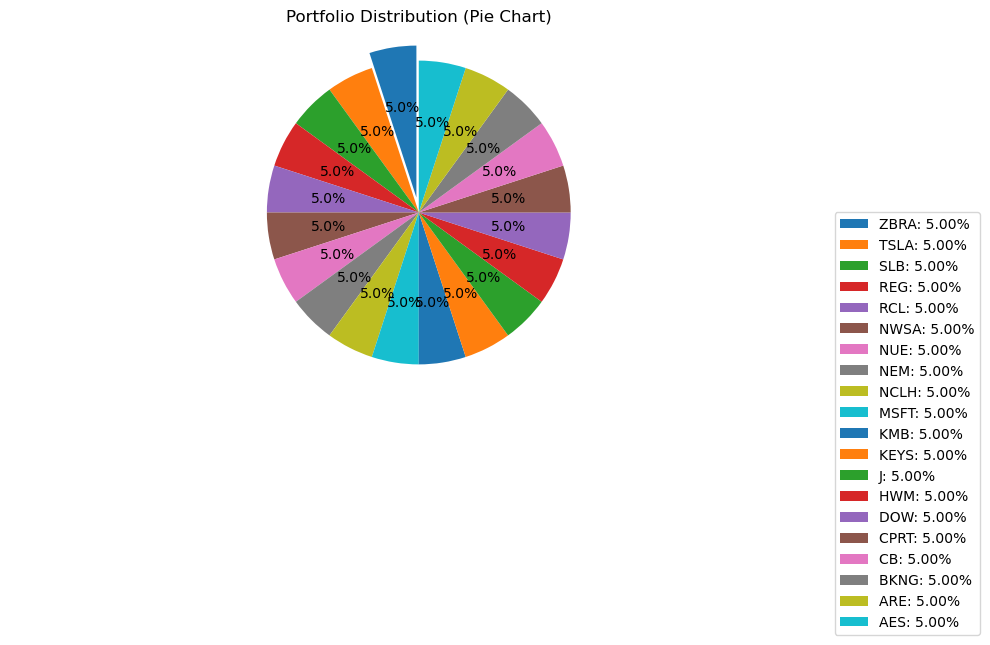

In [33]:
# Choose some 20 keys at random 
random_tickers = np.random.choice(list(all_returns.keys()), 20, replace=False)

# Create a dictionary of returns with only the random tickers
random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}

# Use this dictionary to initialize a Portfolio object
random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")

# Obtain a summary of the portfolio 
random_portfolio.summarize_portfolio()

# Visualize portfolio distribution 
random_portfolio.visualize_portfolio_distribution(kind="pie", figsize=(10, 6))


#### Optimizing the Portfolio 


--- Portfolio Summary After Optimization ---
Portfolio Summary:
Tickers: ['RCL', 'NWSA', 'BKNG', 'KMB', 'NUE', 'ARE', 'NCLH', 'HWM', 'J', 'CB', 'AES', 'TSLA', 'DOW', 'NEM', 'REG', 'ZBRA', 'SLB', 'MSFT', 'KEYS', 'CPRT']
Weights: {'RCL': 3.9553113521235054e-16, 'NWSA': 1.734780861183656e-17, 'BKNG': 0.0, 'KMB': 0.15723878016130413, 'NUE': 1.2817883982517477e-16, 'ARE': 2.074191589324455e-16, 'NCLH': 0.05299872950879556, 'HWM': 0.026531600153022444, 'J': 0.04881442431250017, 'CB': 0.21608916318602714, 'AES': 0.0, 'TSLA': 0.05154474979504348, 'DOW': 0.16037846672946665, 'NEM': 1.3702780783468108e-15, 'REG': 0.114235587828039, 'ZBRA': 2.6767502735458197e-16, 'SLB': 0.013983422391556175, 'MSFT': 0.158185075934242, 'KEYS': 7.286628295305205e-16, 'CPRT': 8.292207500891734e-16}
Portfolio Expected Return: 0.004069315317038763
Portfolio Volatility: 0.012680040060826903
Portfolio Diversification Ratio: 2.4511613602162083
Portfolio Sharpe Ratio: 0.3209229069875187


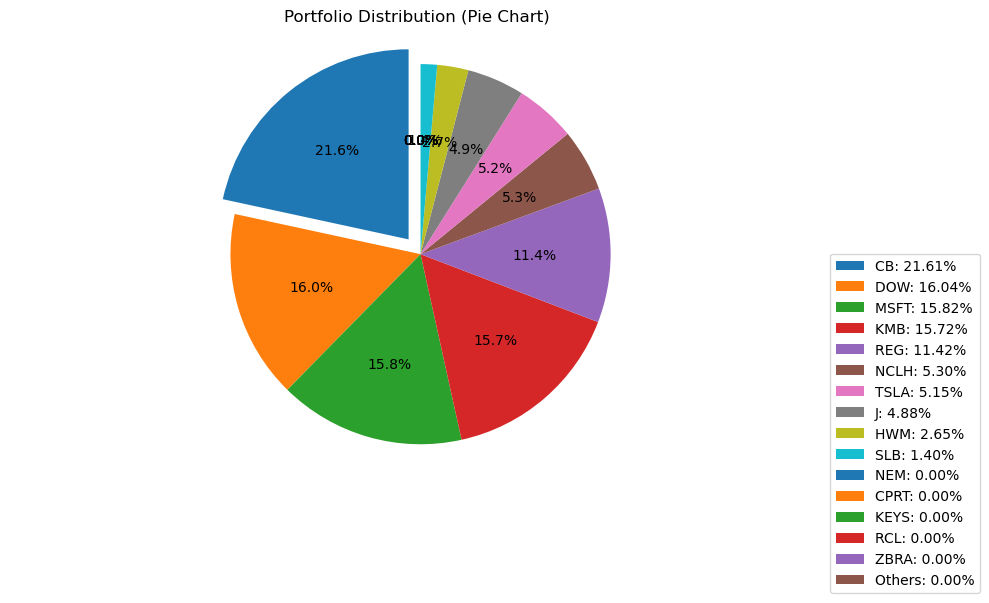

In [34]:
# Optimize portfolio weights 
random_portfolio.optimize_weights(method="max_div", update_weights=True)

# Summarize the portfolio after optimization
print("\n--- Portfolio Summary After Optimization ---")
random_portfolio.summarize_portfolio()

# Visualize the portfolio distribution after optimization
random_portfolio.visualize_portfolio_distribution(kind="pie", figsize=(10, 6))

#### Extracting Portfolio Embeddings

In [28]:
# Define Optim method for both portfolios 
optim_method = "max_div"

# Choose some 20 keys at random 
random_tickers = np.random.choice(list(all_returns.keys()), 15, replace=False)

# Create a dictionary of returns with only the random tickers
random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}

# Use this dictionary to initialize a Portfolio object
random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")

# Optimize portfolio weights 
random_portfolio.optimize_weights(method=optim_method, update_weights=True)

# Generate embeddings for the stock data (full universe of data)
stock_embeddings = generate_embeddings_dict(stock_data, scaler, beta_vae, ticker_col="Ticker")

# Extract embeddings from Portfolio  
random_portfolio_embeddings = {ticker: stock_embeddings[ticker] for ticker in random_portfolio.tickers
                               if ticker in stock_embeddings.keys()}

# Check that number of extracted embeddings == number of portfolio tickers
assert len(random_portfolio_embeddings) == len(random_portfolio.tickers)

# Apply the diversify function to the random portfolio
updated_portfolio, diversification_history, swap_log = diversify_betavae_portfolio(
    portfolio = random_portfolio,
    portfolio_embeddings = random_portfolio_embeddings,
    all_returns = all_returns,
    all_stock_embeddings = stock_embeddings,
    num_iter=200, # number of iterations for the optimization algorithm
    top_N=5, # num top most dissimilar assets to consider for swapping
    optim_algorithm=optim_method,
    distance_type="euclidean"
)

# Print the final diversification ratio and the swap log
print("\nFinal Diversification Ratio:", updated_portfolio.diversification_ratio)
print("Diversification History:", diversification_history)
print("Swap Log (Removed -> Added):", swap_log)


Initial Diversification Ratio: 2.394842386743698


Diversification Iterations:   6%|▋         | 13/200 [00:00<00:01, 121.78it/s]

Accepted Swap: SWK -> MELI
New Diversification Ratio: 2.413636890768311
Accepted Swap: NFLX -> AKAM
New Diversification Ratio: 2.4231310721126986
Accepted Swap: FAST -> EQT
New Diversification Ratio: 2.427955772738781
Accepted Swap: TJX -> CI
New Diversification Ratio: 2.5332413123194413
Accepted Swap: IVZ -> DAL
New Diversification Ratio: 2.572694806789458
Accepted Swap: AMD -> SJM
New Diversification Ratio: 2.6149423860625767


Diversification Iterations:  18%|█▊        | 37/200 [00:00<00:01, 102.85it/s]

Accepted Swap: OMC -> GILD
New Diversification Ratio: 2.6558797933740204


Diversification Iterations: 100%|██████████| 200/200 [00:02<00:00, 71.66it/s]


Final Diversification Ratio: 2.6558797933740204
Diversification History: [2.394842386743698, 2.413636890768311, 2.4231310721126986, 2.427955772738781, 2.5332413123194413, 2.572694806789458, 2.6149423860625767, 2.6558797933740204]
Swap Log (Removed -> Added): {'SWK': 'MELI', 'NFLX': 'AKAM', 'FAST': 'EQT', 'TJX': 'CI', 'IVZ': 'DAL', 'AMD': 'SJM', 'OMC': 'GILD'}


In [29]:
print("\n--- Original Portfolio ---")
# Summarize the original random portfolio
random_portfolio.summarize_portfolio()

print("\n--- Updated Portfolio ---")

# Optimize the updated portfolio weights with max_div 
updated_portfolio.optimize_weights(method="max_div", update_weights=True)

# Summarize the updated portfolio
updated_portfolio.summarize_portfolio()


--- Original Portfolio ---
Portfolio Summary:
Tickers: ['LOW', 'NRG', 'OMC', 'ODFL', 'AMD', 'MSCI', 'CE', 'SWK', 'TJX', 'FAST', 'MKC', 'GOOGL', 'IVZ', 'TSLA', 'NFLX']
Weights: {'LOW': 0.06963556304741567, 'NRG': 0.07505095733978388, 'OMC': 1.872693892190549e-17, 'ODFL': 0.03431927115541622, 'AMD': 8.81714764098968e-17, 'MSCI': 0.11671647088151088, 'CE': 0.10680207958597047, 'SWK': 1.9625477015800695e-16, 'TJX': 0.017756038086820823, 'FAST': 0.032929569591427364, 'MKC': 0.26476982716385, 'GOOGL': 0.14344228308250556, 'IVZ': 1.3118297839407331e-17, 'TSLA': 0.07517136675275841, 'NFLX': 0.06340657331254083}
Portfolio Expected Return: 0.004720662733302652
Portfolio Volatility: 0.01722917518599622
Portfolio Diversification Ratio: 2.394842301200967
Portfolio Sharpe Ratio: 0.27399238108273344

--- Updated Portfolio ---
Portfolio Summary:
Tickers: ['LOW', 'NRG', 'ODFL', 'MSCI', 'CE', 'MKC', 'GOOGL', 'TSLA', 'MELI', 'AKAM', 'EQT', 'CI', 'DAL', 'SJM', 'GILD']
Weights: {'LOW': 2.9441213868764626e

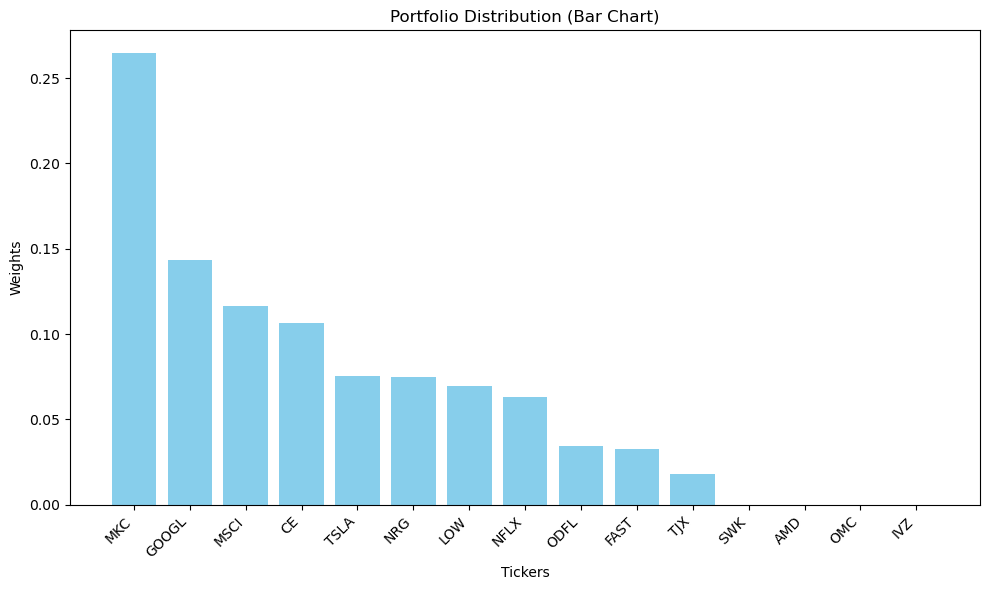

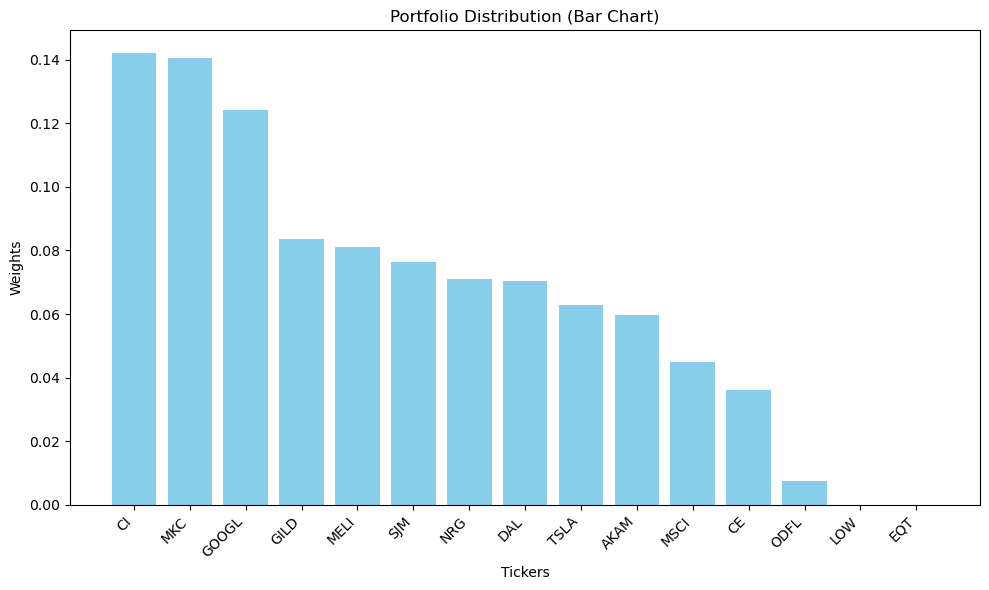

In [ ]:
random_portfolio.visualize_portfolio_distribution(kind="pie", figsize=(10, 6))
updated_portfolio.visualize_portfolio_distribution(kind="pie", figsize=(10, 6))

## Implementing the Full Experiment 

In [31]:
# Initialize storage for portfolio results
portfolio_results = []
portfolio_tickers = {}

# Define number of iterations for diversification process
num_portfolios = 15
num_initial_tickers = 15
optim_method = "max_div"

for i in range(1, num_portfolios + 1):
    # Step 1: Generate random portfolio
    random_tickers = np.random.choice(list(all_returns.keys()), num_initial_tickers, replace=False)
    random_returns = {ticker: all_returns[ticker] for ticker in random_tickers}
    random_portfolio = Portfolio(returns_dict=random_returns, frequency="weekly")
    
    # Optimize initial portfolio
    random_portfolio.optimize_weights(method=optim_method, update_weights=True)
    
    # Record initial DR and SR
    initial_dr = random_portfolio.diversification_ratio
    initial_sr = random_portfolio.sharpe_ratio
    
    # Step 2: Generate embeddings
    random_portfolio_embeddings = {ticker: stock_embeddings[ticker] for ticker in random_portfolio.tickers
                                   if ticker in stock_embeddings.keys()}
    assert len(random_portfolio_embeddings) == len(random_portfolio.tickers)
    
    # Step 3: Apply diversification function
    updated_portfolio, diversification_history, swap_log = diversify_betavae_portfolio(
        portfolio=random_portfolio,
        portfolio_embeddings=random_portfolio_embeddings,
        all_returns=all_returns,
        all_stock_embeddings=stock_embeddings,
        num_iter=200,
        top_N=5,
        optim_algorithm=optim_method,
        distance_type="euclidean", 
        verbose=False
    )
    
    # Optimize the updated portfolio after swaps
    updated_portfolio.optimize_weights(method=optim_method, update_weights=True)
    
    # Record updated DR and SR
    final_dr = updated_portfolio.diversification_ratio
    final_sr = updated_portfolio.sharpe_ratio
    
    # Store tickers for the updated portfolio
    portfolio_tickers[f"Portfolio_{i}"] = updated_portfolio.tickers
    
    # Save results for the dataframe
    portfolio_results.append({
        "Portfolio": f"Portfolio_{i}",
        "Initial_DR": initial_dr,
        "Final_DR": final_dr,
        "Initial_SR": initial_sr,
        "Final_SR": final_sr, 
        "Tickers": updated_portfolio.tickers
    })

# Convert results to a DataFrame
portfolio_results_df = pd.DataFrame(portfolio_results)

# Sort by Final_DR
portfolio_results_df = portfolio_results_df.sort_values(by="Final_DR", ascending=False)


Diversification Iterations: 100%|██████████| 200/200 [00:02<00:00, 74.86it/s]


In [32]:
# Display the table
display(portfolio_results_df)

,Portfolio,Initial_DR,Final_DR,Initial_SR,Final_SR,Tickers
2,Portfolio_3,2.241430,3.427312,0.429601,0.363453,"[STT, LHX, ETR, BR, MRNA, UBER, ZM, CDW, XOM, ..."
3,Portfolio_4,2.843845,3.237850,0.358533,0.281618,"[TRV, WYNN, GDDY, BAX, LEN, FDS, CLX, SJM, UNH..."
10,Portfolio_11,2.029088,3.232198,0.438754,0.460208,"[AJG, PCG, CHTR, MMM, BKNG, UBER, ZM, HPE, MA,..."
5,Portfolio_6,2.960066,3.217680,0.449233,0.339325,"[GEN, DELL, SPOT, PARA, UNH, ETSY, VLTO, ROK, ..."
8,Portfolio_9,2.932502,3.210962,0.498110,0.517348,"[AVGO, TSN, EXR, HOLX, K, DIS, BIIB, ANET, LOW..."
6,Portfolio_7,2.471137,3.109185,0.193619,0.391285,"[TSLA, MOH, CAG, LVS, WST, AIG, SJM, XOM, FITB..."
12,Portfolio_13,3.079215,3.105189,0.328046,0.326887,"[AKAM, DIS, CE, HSY, ALB, MU, NFLX, NCLH, COST..."
13,Portfolio_14,2.856674,2.924265,0.328322,0.284287,"[ZTS, PARA, STLD, ON, ADBE, GEN, SNOW, ES, T, ..."
9,Portfolio_10,2.803151,2.903365,0.414807,0.382708,"[HUBB, HBAN, SO, CCL, NWS, LRCX, DUK, UNH, AIG..."
1,Portfolio_2,2.274073,2.898467,0.419743,0.539998,"[FAST, YUM, ABBV, PEG, SBAC, EXPE, AIG, TYL, C..."


In [ ]:
# disply sorted by final SR
display(portfolio_results_df.sort_values(by="Final_SR", ascending=False))


,Portfolio,Initial_DR,Final_DR,Initial_SR,Final_SR,Tickers
1,Portfolio_2,2.274073,2.898467,0.419743,0.539998,"[FAST, YUM, ABBV, PEG, SBAC, EXPE, AIG, TYL, C..."
8,Portfolio_9,2.932502,3.210962,0.498110,0.517348,"[AVGO, TSN, EXR, HOLX, K, DIS, BIIB, ANET, LOW..."
11,Portfolio_12,2.296255,2.836176,0.380410,0.490407,"[MS, CME, SRE, APD, ROK, SJM, NWS, AIG, BKNG, ..."
4,Portfolio_5,2.556377,2.594252,0.524032,0.481833,"[HUBB, BR, ACGL, LRCX, FDX, FOXA, RL, DAL, GDD..."
10,Portfolio_11,2.029088,3.232198,0.438754,0.460208,"[AJG, PCG, CHTR, MMM, BKNG, UBER, ZM, HPE, MA,..."
0,Portfolio_1,2.228764,2.579703,0.440131,0.437223,"[PPG, WELL, SYY, AMZN, COF, HPE, TXT, MRK, AIG..."
6,Portfolio_7,2.471137,3.109185,0.193619,0.391285,"[TSLA, MOH, CAG, LVS, WST, AIG, SJM, XOM, FITB..."
9,Portfolio_10,2.803151,2.903365,0.414807,0.382708,"[HUBB, HBAN, SO, CCL, NWS, LRCX, DUK, UNH, AIG..."
2,Portfolio_3,2.241430,3.427312,0.429601,0.363453,"[STT, LHX, ETR, BR, MRNA, UBER, ZM, CDW, XOM, ..."
14,Portfolio_15,2.729832,2.729832,0.363316,0.363302,"[RMD, FOX, PH, VTRS, PG, NVO, SRE, JBL, AFL, M..."


: 